In [1]:
import os
import pandas as pd
from activity_count_function import *
from zurich_move_group_function import *
from zurich_move_pipeline_function import find_optimal_threshold
from zurich_move_utilites import get_statistics

C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\Pierre-Louis\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Group ROC 

In [3]:
#Get counts and masks files @ 1 Hz
count_brond_LW_csv_files = find_files_with_extension('count_brond_LW.csv')
count_brond_RW_csv_files = find_files_with_extension('count_brond_RW.csv')
GT_mask_LW_csv_files = find_files_with_extension('GT_mask_LW_1Hz.csv')
GT_mask_RW_csv_files = find_files_with_extension('GT_mask_RW_1Hz.csv')

In [4]:
def get_resampled_data_from_csv(csv_files, mask=False):
    """
    Resamples data from CSV files to match the smallest length among the arrays.

    Args:
        csv_files (list): List of CSV file paths.
        mask (bool): Boolean flag indicating whether the data is a mask.

    Returns:
        np.ndarray: NumPy array of resampled data arrays.
    """
    all_data = []

    # Find the shortest length among all the arrays
    min_length = float('inf')

    for csv_file in csv_files:
        # Read the CSV file and extract the data
        df = pd.read_csv(csv_file)
        data = df.iloc[:, 0].values

        # Update the minimum length
        min_length = min(min_length, len(data))

        all_data.append(data)

    # Cubic spline interpolation to match the smaller array size
    resampled_data = []

    for data in all_data:
        # Perform cubic spline interpolation
        x = np.arange(len(data))
        cs = CubicSpline(x, data, extrapolate=False)  # Set extrapolate to False
        resampled_values = cs(np.linspace(0, len(data) - 1, min_length))

        # Round the interpolated values to the nearest integer if it is a mask
        if mask:
            resampled_values = np.round(resampled_values).astype(int)

        resampled_data.append(resampled_values)

    return np.array(resampled_data)

In [5]:
def concatenate_array(array_of_arrays):
    """
    Concatenates an array of arrays into a single array.

    Args:
        array_of_arrays (np.ndarray): Array of arrays to be concatenated.

    Returns:
        np.ndarray: Concatenated array.
    """
    return np.concatenate(array_of_arrays, axis=0)

In [6]:
AC_LW_group = concatenate_array(get_resampled_data_from_csv(count_brond_LW_csv_files))
AC_RW_group = concatenate_array(get_resampled_data_from_csv(count_brond_RW_csv_files))

GT_mask_LW_group = concatenate_array(get_resampled_data_from_csv(GT_mask_LW_csv_files, mask=True))
GT_mask_RW_group = concatenate_array(get_resampled_data_from_csv(GT_mask_RW_csv_files, mask=True))

In [7]:
print(AC_LW_group.shape,GT_mask_LW_group.shape )

(2466,) (2466,)


In [8]:
AC_LW_group,GT_mask_LW_group

(array([524.96571317, 504.41037739,  45.30254502, ..., 126.46291107,
        161.44708744, 116.08617489]),
 array([1, 1, 0, ..., 0, 0, 1]))

In [9]:
# Perform ROC for the entire group 

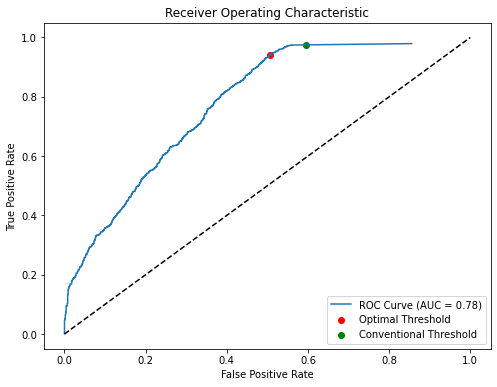

AUC: 0.78
Optimal Threshold: 9.13
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)


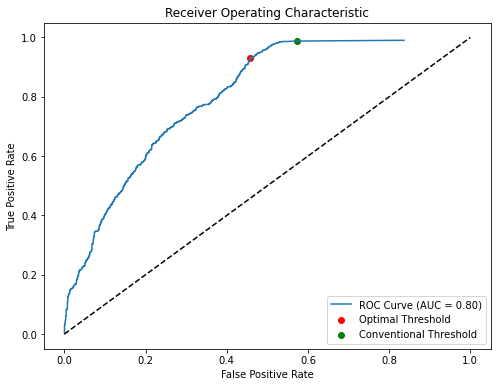

AUC: 0.80
Optimal Threshold: 25.64
Conventional Threshold: 2.00
AUC is clinically useful (≥0.75)


In [10]:
conventional_threshold_unilateral = 2
optimal_threshold_LW_group = find_optimal_threshold(GT_mask_LW_group, AC_LW_group, conventional_threshold_unilateral)
optimal_threshold_RW_group = find_optimal_threshold(GT_mask_RW_group, AC_RW_group, conventional_threshold_unilateral)

In [11]:
# Individuals boxplots 

In [12]:
evaluation_csv_files = find_files_with_extension('evaluation_metrics.csv')

In [13]:
group_metrics = regroup_field_data(evaluation_csv_files)

In [14]:
group_metrics

{'OT_LW_Sensitivity': [91.95402298850574,
  98.28326180257511,
  87.28813559322035],
 'OT_LW_Specificity': [50.42016806722689, 54.7752808988764, 52.22222222222223],
 'OT_LW_Accuracy': [76.60455486542443, 79.44038929440389, 72.11538461538461],
 'OT_LW_PPV': [75.98371777476255, 73.99030694668821, 70.54794520547945],
 'OT_LW_NPV': [78.60262008733623, 96.05911330049261, 75.80645161290323],
 'OT_RW_Sensitivity': [97.04433497536947,
  98.49462365591398,
  95.77464788732394],
 'OT_RW_Specificity': [52.66106442577031,
  49.01960784313725,
  53.13432835820896],
 'OT_RW_Accuracy': [80.64182194616977, 77.00729927007299, 78.60576923076923],
 'OT_RW_PPV': [77.76315789473685, 71.5625, 75.19747235387045],
 'OT_RW_NPV': [91.2621359223301, 96.15384615384616, 89.44723618090453],
 'OT_bilateral_Sensitivity': [89.49343339587243,
  96.52605459057072,
  84.17266187050359],
 'OT_bilateral_Specificity': [46.88221709006928,
  47.49403341288782,
  53.493975903614455],
 'OT_bilateral_Accuracy': [70.3933747412008

In [15]:
threshold_labels = ['CT', 'OT']
side_labels = ['LW', 'RW', 'bilateral']
metric_labels = ['Sensitivity', 'Specificity', 'Accuracy', 'PPV', 'NPV']

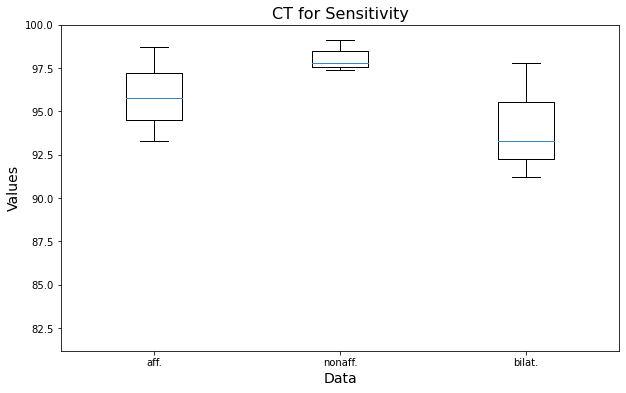

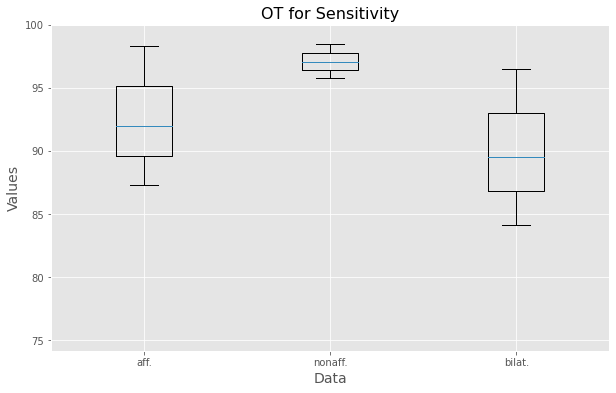

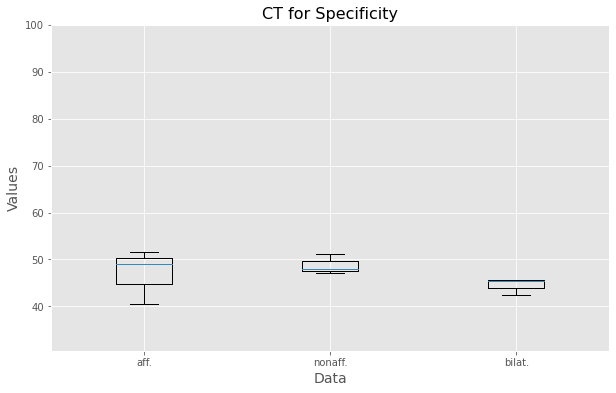

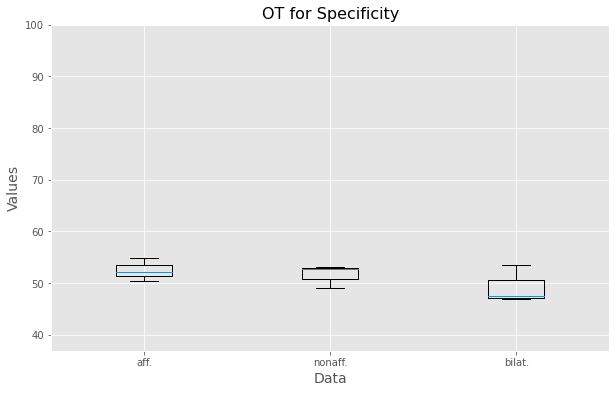

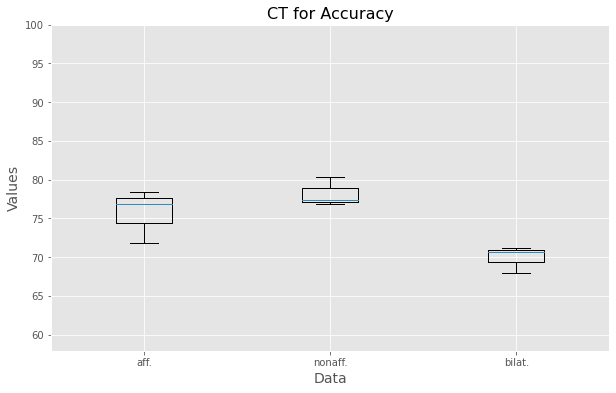

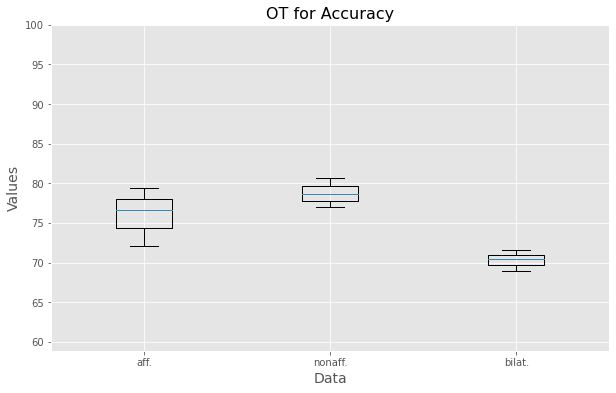

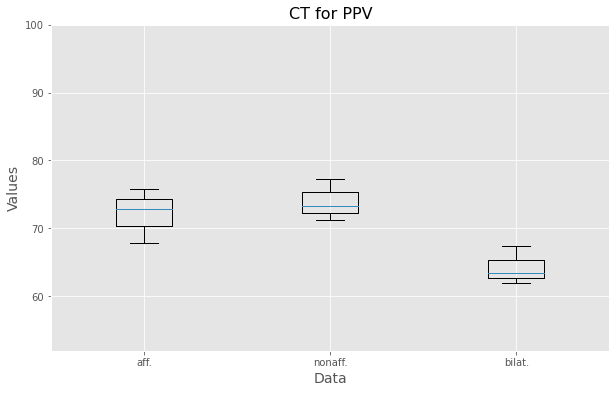

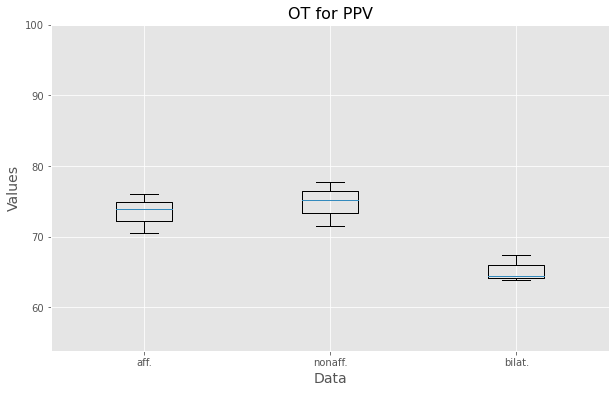

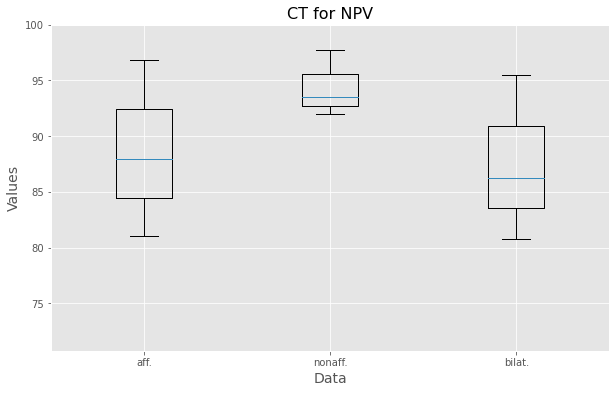

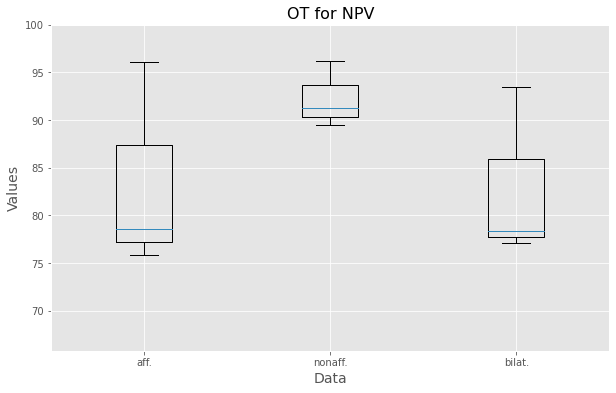

In [16]:
for metric in metric_labels:
    for threshold in threshold_labels: 
        data_list, title = get_metrics_list(group_metrics, threshold, metric, side_labels)
        plot_vertical_whisker(data_list, title)